In [1]:
from os import path as osp
import sys

import pandas as pd
import numpy as np
import quaternion
import random

from data_utils import CompiledSequence
from scipy.ndimage import gaussian_filter1d
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
class OxfordGlobSpeedSequence(CompiledSequence):
    """
    Dataset :- Oxford (can be downloaded from https://drive.google.com/file/d/1UCHY3ENCybcBNyiC2wx1gQEWSLqzJag0/view)
    Features :- raw angular rate and acceleration (includes gravity).
    """
    feature_dim = 6
    target_dim = 2
    aux_dim = 8

    def __init__(self, data_path=None, **kwargs):
        super().__init__(**kwargs)
        self.ts, self.features, self.targets, self.orientations, self.gt_pos = None, None, None, None, None

        self.w = kwargs.get('interval', 1) #default interval will be one, if 'interval' is not given
        if data_path is not None:
            self.load(data_path)

    def load(self, data_path):
        if data_path[-1] == '/':
            data_path = data_path[:-1]
        
        
        data = pd.read_csv(data_path).dropna()
        data = self.clean_Data(data)

        column_names = ['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)','rotation_rate_z(radians/s)', 'user_acc_x(G)', 'user_acc_y(G)',
                        'user_acc_z(G)', 'translation.x', 'translation.y', 'translation.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']

        data.columns = column_names
        # Print the modified DataFrame
        #display(data)
        
        
        gyro = data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].values
        #convert acceleration into metre per second square instead of in terms of gravity
        data[['user_acc_x(m/s2)', 'user_acc_y(m/s2)', 'user_acc_z(m/s2)']] = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] * 9.81
        acce = data[['user_acc_x(m/s2)', 'user_acc_y(m/s2)', 'user_acc_z(m/s2)']].values
        
        #Add in the time data. The time data will be an estimate based on the fact that the frequency of IMU sampling (100Hz)
        time_arr = np.linspace(0, len(data)*0.01, num = len(data))
        data['Time(s)'] = time_arr
        ts = time_arr
        gt_pos = data[['translation.x', 'translation.y', 'translation.z']].values

        dt = (ts[self.w:] - ts[:-self.w])[:, None]
        glob_v = (gt_pos[self.w:] - gt_pos[:-self.w]) / dt #global velocity that takes displacement divide by time
        
        #change velocity values that are greater than 8m/s to be the average of the surrounding values
        outlier_index = np.argwhere(np.logical_or(glob_v >= 5, glob_v <= -5))
        for index in outlier_index:
            idx = index[0]
            glob_v_slice = glob_v[idx:idx + 5, index[1]]
            avg_slice = (np.average(glob_v_slice) + np.average(glob_v[idx - 5:idx, index[1]])) / 2
            glob_v[idx, index[1]] = avg_slice
        
        

        
        # Right now, ori_q is using the ground truth rotation quaternion
        ori = data[['rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']]
        ori_q = quaternion.from_float_array(ori)
        
        #convert to quaternion in order to do quaternion operation, through padding of zeroes. The new quaternion will then have the pads removed 
        gyro_q = quaternion.from_float_array(np.concatenate([np.zeros([gyro.shape[0], 1]), gyro], axis=1))
        acce_q = quaternion.from_float_array(np.concatenate([np.zeros([acce.shape[0], 1]), acce], axis=1))
        glob_gyro = quaternion.as_float_array(ori_q * gyro_q * ori_q.conj())[1:, 1:]
        glob_acce = quaternion.as_float_array(ori_q * acce_q * ori_q.conj())[1:, 1:]

        start_frame = 0
        self.ts = ts[start_frame:]
        self.features = np.concatenate([glob_gyro, glob_acce], axis=1)[start_frame:]
        self.targets = glob_v[start_frame:, :2]
        self.orientations = quaternion.as_float_array(ori_q)[start_frame:]
        self.gt_pos = gt_pos[start_frame:]

    def clean_Data(self, data):
        def split_consecutive_numbers(lst):
            sublists = []
            sublist = []

            for i in range(len(lst)):
                if not sublist or lst[i] == sublist[-1] + 1:
                    sublist.append(lst[i])
                else:
                    sublists.append(sublist)
                    sublist = [lst[i]]

            if sublist:
                sublists.append(sublist)

            return sublists
        #remove values that were not recorded properly, namely those that are at position (0,0,0) even after two seconds
        indexes = data[(data['translation.x'] == 0) & (data['translation.y'] == 0) & (data.index >= 200)].index
        sublists = split_consecutive_numbers(indexes)
        for sublist in sublists:
            first_index = sublist[0]
            last_index = sublist[-1]
            data['translation.x'].iloc[sublist] = np.linspace(data['translation.x'][first_index-1], data['translation.x'][last_index+1], len(sublist))
            data['translation.y'].iloc[sublist] = np.linspace(data['translation.y'][first_index-1], data['translation.y'][last_index+1], len(sublist))
        return data
    
    def get_feature(self):
        return self.features

    def get_target(self):
        return self.targets

    def get_aux(self):
        aux = np.concatenate([self.ts[:, None], self.orientations, self.gt_pos], axis=1)
        return aux

    # def get_meta(self):
    #     return '{}: device: {}, ori_error ({}): {:.3f}'.format(
    #         self.info['path'], self.info['device'], self.info['ori_source'], self.info['source_ori_error'])
    

In [25]:
class SequenceToSequenceDataset(Dataset):
    def __init__(self, seq_type, root_dir, data_list, cache_path=None, step_size=10, window_size=200, random_shift=0, transform=None, **kwargs):
        super(SequenceToSequenceDataset, self).__init__()
        self.feature_dim = seq_type.feature_dim
        self.target_dim = seq_type.target_dim
        self.aux_dim = seq_type.aux_dim
        self.window_size = window_size
        self.step_size = step_size
        self.random_shift = random_shift
        self.transform = transform

        self.data_path = [osp.join(root_dir, data) for data in data_list]
        self.index_map = []
        self.ts, self.orientations, self.gt_pos = [], [], []
        self.features, self.targets, aux = [], [], []
        
  
        for i in range(len(data_list)):
            seq = seq_type(osp.join(root_dir, data_list[i]), **kwargs)
            self.features.append(seq.get_feature())
            self.targets.append(seq.get_target())
            aux.append(seq.get_aux())
        
        #CAN ADD SMOOTHING HERE
        
        for i in range(len(data_list)):            
            self.features[i] = self.features[i][:-1] 
            self.targets[i] = self.targets[i]
            self.ts.append(aux[i][:-1, :1])
            self.orientations.append(aux[i][:-1, 1:5])
            self.gt_pos.append(aux[i][:-1, -3:])
            
            max_norm = kwargs.get('max_velocity_norm', 3.0)
            velocity = np.linalg.norm(self.targets[i], axis=1)  # Remove outlier ground truth data
            bad_data = velocity > max_norm
            for j in range(window_size + random_shift, self.targets[i].shape[0], step_size):
                if not bad_data[j - window_size - random_shift:j + random_shift].any():
                    self.index_map.append([i, j])

        if kwargs.get('shuffle', True):
            random.shuffle(self.index_map)
            
        
    def __getitem__(self, item):
        
        seq_id, frame_id = self.index_map[item][0], self.index_map[item][1]
        
        if self.random_shift > 0:
            frame_id += random.randrange(-self.random_shift, self.random_shift)
            frame_id = max(self.window_size, min(frame_id, self.targets[seq_id].shape[0] - 1))

        #frame_id = min(frame_id, self.targets[seq_id].shape[0] - self.window_size)
        feat = np.copy(self.features[seq_id][frame_id - self.window_size:frame_id])
        targ = np.copy(self.targets[seq_id][frame_id - self.window_size:frame_id])

        if self.transform is not None:
            feat, targ = self.transform(feat, targ)

        return feat.astype(np.float32), targ.astype(np.float32), seq_id, frame_id

    def __len__(self):
        return len(self.index_map)
    
    def get_test_seq(self, i):
        return self.features[i].astype(np.float32)[np.newaxis,], self.targets[i].astype(np.float32)

In [28]:
from transformations import *
def get_dataset(root_dir, data_list, **kwargs):
    input_format, output_format = [0, 3, 6], [0, 2]
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, [], False

    if mode == 'train':
        random_shift = step_size // 2
        shuffle = True
        transforms.append(RandomHoriRotateSeq(input_format, output_format))
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True
    transforms = ComposeTransform(transforms)

    seq_type = OxfordGlobSpeedSequence
    dataset = SequenceToSequenceDataset(seq_type, root_dir, data_list, None, step_size = step_size, window_size = window_size,
                                        random_shift=random_shift, transform=transforms, shuffle=shuffle,
                                        grv_only=grv_only)

    return dataset


def get_dataset_from_list(root_dir, list_path, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, **kwargs)


In [38]:
from torch.utils.data import DataLoader
step_size = 10
window_size = 200
train_dataset = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/large scale', ['floor4/combined3.csv'], mode='test', step_size = step_size, window_size = 200)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last = True)

In [39]:
train_dataset.features[0].shape

(16201, 6)

In [40]:
targ_all = []
for bid, (feat, targ, _, _) in enumerate(train_loader):
    print(feat.shape)


torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])
torch.Size([128, 200, 6])


In [407]:
targ_all.shape

(1536, 2)

In [408]:
np.max(targ_all)

4.8097034

In [400]:
index = np.argwhere(targ_all == np.min(targ_all))
print(index)
print(np.min(targ_all))

[[329   0]
 [341   0]]
-2.6998334


ValueError: x and y must have same first dimension, but have shapes (43640,) and (16215,)

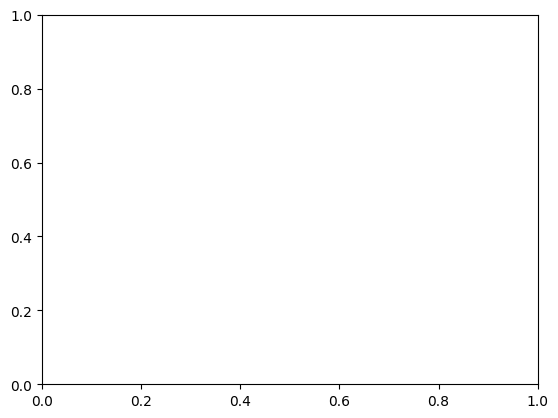

In [401]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 43640,43640), glob_v[:,0])

In [325]:
from scipy.interpolate import interp1d
pos_pred = recon_traj_with_preds(train_dataset, np.array(targ_all))[:, :2]
pos_gt = train_dataset.gt_pos[0][:, :2]

In [326]:
pos_pred

array([[ 0.039513  , -0.0094998 ],
       [ 0.03934401, -0.009437  ],
       [ 0.03922602, -0.00931671],
       ...,
       [ 0.33765406,  1.02660786],
       [ 0.33735407,  1.01510857],
       [ 0.33735407,  1.01510857]])

In [328]:
pos_gt

array([[ 0.039513 , -0.0094998],
       [ 0.039344 , -0.009437 ],
       [ 0.039179 , -0.0093787],
       ...,
       [-1.8997   ,  0.30475  ],
       [-1.8997   ,  0.30475  ],
       [-1.8997   ,  0.30464  ]])

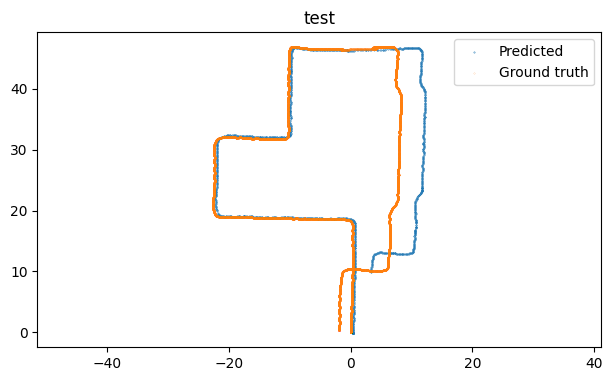

In [332]:
import matplotlib.pyplot as plt
kp = 2
plt.figure('{}'.format('Test'), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.scatter(pos_pred[:, 0], pos_pred[:, 1], s=0.1)
plt.scatter(pos_gt[:, 0], pos_gt[:, 1], s = 0.01)
plt.title('test')
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])

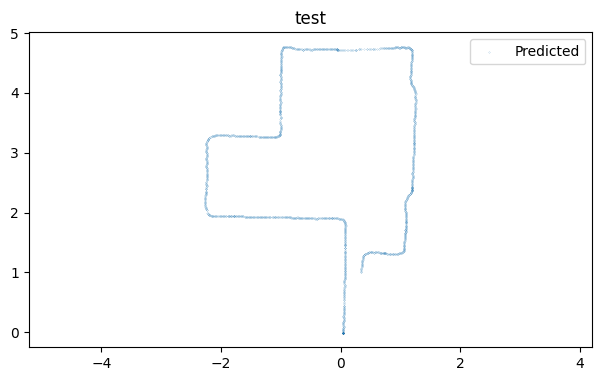

In [330]:
import matplotlib.pyplot as plt
kp = 2
plt.figure('{}'.format('Test'), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.scatter(pos_pred[:, 0], pos_pred[:, 1], s=0.01)
#plt.scatter(pos_gt[:, 0], pos_gt[:, 1], s = 0.1)
plt.title('test')
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])